# Caso Técnico Xepelin
# SkForecast con Variables Exógenas
#### Florencia Margara
#### Fecha: 2022-08-26

## Import Libs

In [155]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

# Modelado y Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

from utils.helper_functions import process_metrics

from joblib import dump, load

# Configuración warnings
# ==============================================================================
import warnings
# warnings.filterwarnings('ignore')

## Load Data

In [156]:
# Descarga de datos
# ==============================================================================
datos = pd.read_csv('data/data_final_lag_amount.csv', parse_dates = ['period'])
datos = datos.drop('Unnamed: 0', axis=1)
datos

,period,totalAmount,freq,freqFinanced,meanAmount,totalFinanced,meanFinanced,freqPayers,freqReceiver
0,2021-11-01,268349.19,5,1,7180.53,10520.15,2104.03,5,5
1,2021-12-01,753946.49,13,8,20642.25,119352.51,9180.96,13,12
2,2022-01-01,7283045.52,17,7,44349.79,592831.07,34872.42,16,16
3,2022-02-01,7100660.51,107,43,68065.85,5219511.13,48780.48,83,56
4,2022-03-01,5765920.25,183,45,38801.42,4485712.42,24512.09,115,65
5,2022-04-01,5042399.69,225,49,25626.31,2344379.98,10419.47,137,68
6,2022-05-01,1180788.62,269,50,18744.98,3057870.38,11367.55,153,73


In [157]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   period         7 non-null      datetime64[ns]
 1   totalAmount    7 non-null      float64       
 2   freq           7 non-null      int64         
 3   freqFinanced   7 non-null      int64         
 4   meanAmount     7 non-null      float64       
 5   totalFinanced  7 non-null      float64       
 6   meanFinanced   7 non-null      float64       
 7   freqPayers     7 non-null      int64         
 8   freqReceiver   7 non-null      int64         
dtypes: datetime64[ns](1), float64(4), int64(4)
memory usage: 632.0 bytes


In [158]:
# Preparación del dato
# ==============================================================================
datos = datos.set_index('period')
datos = datos.rename(columns={'totalAmount': 'y', 'freq': 'qPayments'})
exog_cols = ['qPayments','freqFinanced','meanAmount','totalFinanced','meanFinanced','freqPayers','freqReceiver']
datos = datos.asfreq('MS')
datos = datos.sort_index()
datos.head()

,y,qPayments,freqFinanced,meanAmount,totalFinanced,meanFinanced,freqPayers,freqReceiver
period,,,,,,,,
2021-11-01,268349.19,5,1,7180.53,10520.15,2104.03,5,5
2021-12-01,753946.49,13,8,20642.25,119352.51,9180.96,13,12
2022-01-01,7283045.52,17,7,44349.79,592831.07,34872.42,16,16
2022-02-01,7100660.51,107,43,68065.85,5219511.13,48780.48,83,56
2022-03-01,5765920.25,183,45,38801.42,4485712.42,24512.09,115,65


In [159]:
print(f'Número de filas con missing values: {datos.isnull().any(axis=1).mean()}')

Número de filas con missing values: 0.0


In [160]:
# Verificar que el índice temporal está completo
# ==============================================================================
(datos.index == pd.date_range(
                    start = datos.index.min(),
                    end   = datos.index.max(),
                    freq  = datos.index.freq)
).all()

True

Fechas train : 2021-11-01 00:00:00 --- 2022-04-01 00:00:00  (n=6)
Fechas test  : 2022-05-01 00:00:00 --- 2022-05-01 00:00:00  (n=1)


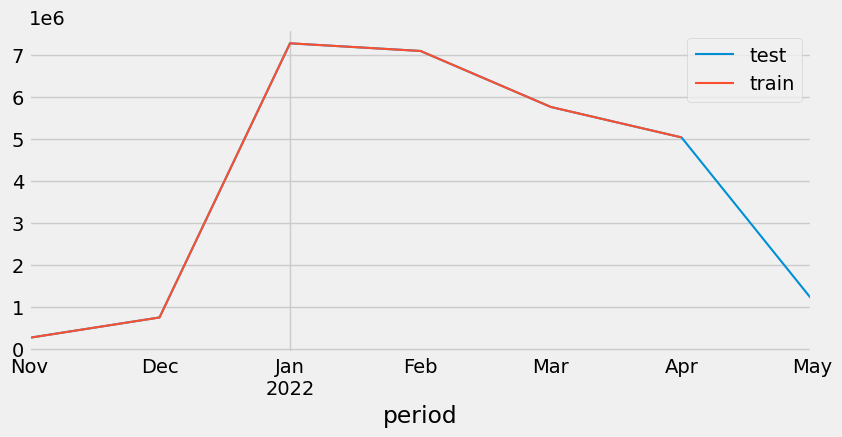

In [161]:
# Separación datos train-test
# ==============================================================================
steps = 1
datos_train = datos[:-steps]
datos_test  = datos[-steps:]

print(f"Fechas train : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas test  : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

fig, ax = plt.subplots(figsize=(9, 4))
pd.concat([datos_train['y'],datos_test['y']]).plot(ax=ax, label='test')
datos_train['y'].plot(ax=ax, label='train')
ax.legend();

## ForecasterAutoreg

In [162]:
# Crear y entrenar forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags = 1
             )

forecaster.fit(y=datos_train['y'], exog=datos_train[exog_cols])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1] 
Window size: 1 
Included exogenous: True 
Type of exogenous variable: <class 'pandas.core.frame.DataFrame'> 
Exogenous variables names: ['qPayments', 'freqFinanced', 'meanAmount', 'totalFinanced', 'meanFinanced', 'freqPayers', 'freqReceiver'] 
Training range: [Timestamp('2021-11-01 00:00:00'), Timestamp('2022-04-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2022-08-27 11:46:43 
Last fit date: 2022-08-27 11:46:43 
Skforecast version: 0.4.3 

## Predicts

In [163]:
# Predicciones
# ==============================================================================
predicciones = forecaster.predict(steps=steps, exog=datos_test[exog_cols])
predicciones

2022-05-01   4461863.33
Freq: MS, Name: pred, dtype: float64

In [222]:
df_final_real = pd.concat([datos_train['y'],datos_test['y']])
df_final_pred = pd.concat([datos_train['y'],predicciones])

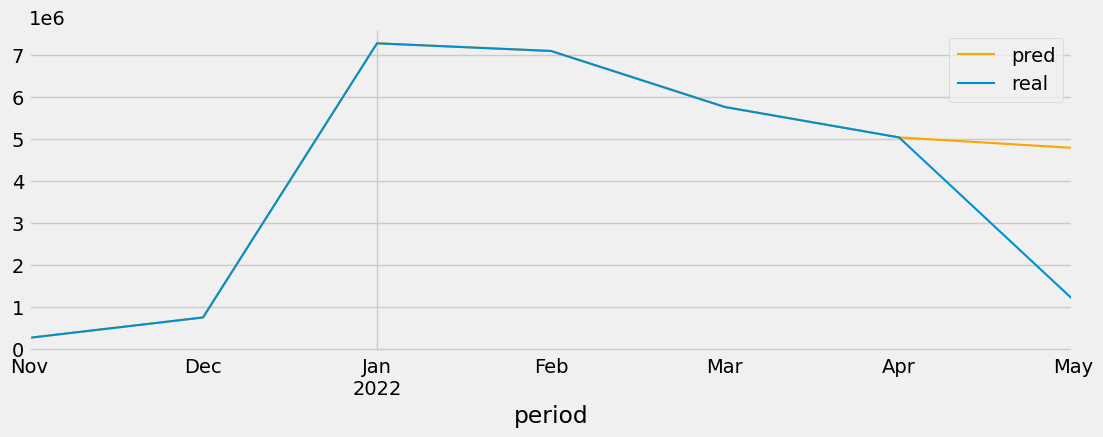

In [223]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(12, 4))

df_final_pred.plot(ax=ax, label='pred', color ='orange')
df_final_real.plot(ax=ax, label='real')

ax.legend();

## Metrics

In [166]:
y_true = datos_test['y'],
y_pred = predicciones

In [167]:
# Error test
# ==============================================================================
error_mse = mean_squared_error(
                y_true,
                y_pred
            )

print(f"Error de test (mse): {error_mse}")

Error de test (mse): 10765451268350.74


In [168]:
process_metrics(y_true, y_pred )

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'MAE': 3281074.7123999996,
 'MSE': 10765451268350.74,
 'RMSE': 3281074.7123999996,
 'RMSLogE': 15.003681582912263,
 'r2': nan}

## Hyperparameter Tuning

In [213]:
# Grid search de hiperparámetros
# ==============================================================================
steps = 1
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 1 # Este valor será remplazado en el grid search
             )

# Lags utilizados como predictores
lags_grid = [1]

# Hiperparámetros del regresor
param_grid = {'n_estimators': [5,10,50,100,250,500],
              'max_depth': [2,3,4,5,8,10]}

resultados_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = datos_train['y'],
                        exog               = datos_train[exog_cols],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(datos_train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
                   )

Number of models compared: 36


loop lags_grid: 100%|███████████████████████████████████████| 1/1 [00:05<00:00,  5.99s/it]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1] 
  Parameters: {'max_depth': 4, 'n_estimators': 500}
  Backtesting metric: 1141494148875.467



Como se ha indicado return_best = True en grid_search_forecaster, tras la búsqueda, el objeto ForecasterAutoreg ha sido modificado y entrenado con la mejor combinación encontrada.

In [214]:
# Resultados Grid Search
# ==============================================================================
resultados_grid.head()

,lags,params,metric,max_depth,n_estimators
17,[1],"{'max_depth': 4, 'n_estimators': 500}",1141494148875.47,4,500
29,[1],"{'max_depth': 8, 'n_estimators': 500}",1141494148875.47,8,500
23,[1],"{'max_depth': 5, 'n_estimators': 500}",1141494148875.47,5,500
11,[1],"{'max_depth': 3, 'n_estimators': 500}",1141494148875.47,3,500
5,[1],"{'max_depth': 2, 'n_estimators': 500}",1141494148875.47,2,500


## Predicts

In [215]:
# Predicciones
# ==============================================================================
predicciones = forecaster.predict(steps=steps, exog=datos_test[exog_cols])
predicciones

2022-05-01   4792371.60
Freq: MS, Name: pred, dtype: float64

In [216]:
df_final_real = pd.concat([datos_train['y'],datos_test['y']])
df_final_pred = pd.concat([datos_train['y'],predicciones])

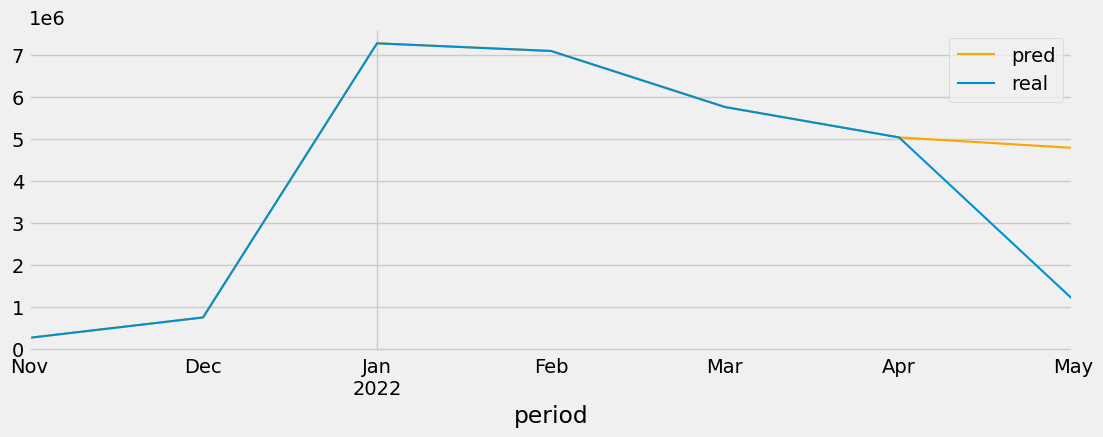

In [224]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(12, 4))

df_final_pred.plot(ax=ax, label='pred', color ='orange')
df_final_real.plot(ax=ax, label='real')

ax.legend();

## Metrics

In [218]:
y_true = datos_test['y'],
y_pred = predicciones

In [219]:
# Error test
# ==============================================================================
error_mse = mean_squared_error(
                y_true,
                y_pred
            )

print(f"Error de test (mse): {error_mse}")

Error de test (mse): 13043531634138.646


In [220]:
process_metrics(y_true, y_pred )

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'MAE': 3611582.981760027,
 'MSE': 13043531634138.646,
 'RMSE': 3611582.981760027,
 'RMSLogE': 15.099656733298929,
 'r2': nan}

## Feature Importance

In [177]:
# Importancia predictores
# ==============================================================================
impotancia = forecaster.get_feature_importance()
impotancia.sort_values('importance', ascending=False)

,feature,importance
1,qPayments,0.14
5,meanFinanced,0.14
6,freqPayers,0.14
7,freqReceiver,0.14
3,meanAmount,0.14
0,lag_1,0.11
4,totalFinanced,0.10
2,freqFinanced,0.09


## Predecimos el mes de Junio

In [178]:
# Descarga de datos
# ==============================================================================
datos = pd.read_csv('data/data_final_lag_amount.csv', parse_dates = ['period'])
datos = datos.drop('Unnamed: 0', axis=1)
datos

,period,totalAmount,freq,freqFinanced,meanAmount,totalFinanced,meanFinanced,freqPayers,freqReceiver
0,2021-11-01,268349.19,5,1,7180.53,10520.15,2104.03,5,5
1,2021-12-01,753946.49,13,8,20642.25,119352.51,9180.96,13,12
2,2022-01-01,7283045.52,17,7,44349.79,592831.07,34872.42,16,16
3,2022-02-01,7100660.51,107,43,68065.85,5219511.13,48780.48,83,56
4,2022-03-01,5765920.25,183,45,38801.42,4485712.42,24512.09,115,65
5,2022-04-01,5042399.69,225,49,25626.31,2344379.98,10419.47,137,68
6,2022-05-01,1180788.62,269,50,18744.98,3057870.38,11367.55,153,73


In [179]:
# Preparación del dato
# ==============================================================================
datos = datos.set_index('period')
datos = datos.rename(columns={'totalAmount': 'y', 'freq': 'qPayments'})
exog_cols = ['qPayments','freqFinanced','meanAmount','totalFinanced','meanFinanced','freqPayers','freqReceiver']
datos = datos.asfreq('MS')
datos = datos.sort_index()
datos.head()

,y,qPayments,freqFinanced,meanAmount,totalFinanced,meanFinanced,freqPayers,freqReceiver
period,,,,,,,,
2021-11-01,268349.19,5,1,7180.53,10520.15,2104.03,5,5
2021-12-01,753946.49,13,8,20642.25,119352.51,9180.96,13,12
2022-01-01,7283045.52,17,7,44349.79,592831.07,34872.42,16,16
2022-02-01,7100660.51,107,43,68065.85,5219511.13,48780.48,83,56
2022-03-01,5765920.25,183,45,38801.42,4485712.42,24512.09,115,65


In [180]:
# Predicciones
# ==============================================================================
predicciones = forecaster.predict(steps=steps, exog=datos[exog_cols])
predicciones.values

array([3151029.82906])

In [181]:
pred = pd.DataFrame(predicciones.values, columns=['y'], index=['2022-06-01 00:00:00'])
pred.index = pred.index.astype("datetime64[ns]")

In [182]:
df_final_real = pd.DataFrame(datos['y'], columns=['y'])
df_final_pred = pd.concat([pd.DataFrame(datos['y'], columns=['y']),pred])

In [183]:
df_final_pred

,y
2021-11-01,268349.19
2021-12-01,753946.49
2022-01-01,7283045.52
2022-02-01,7100660.51
2022-03-01,5765920.25
2022-04-01,5042399.69
2022-05-01,1180788.62
2022-06-01,3151029.83


<AxesSubplot:xlabel='period'>

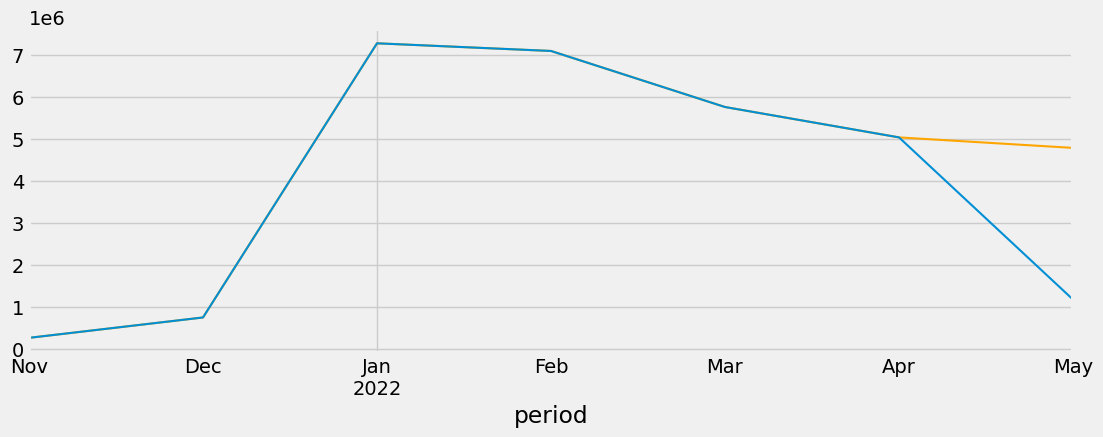

In [229]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(12, 4))

df_final_pred.plot(ax=ax, label='pred', color ='orange')
df_final_real.plot(ax=ax, label='real')

#ax.legend();